In [1]:
import sys
import os
import time
import random
import re
import glob
from meidic_vtach_utils.run_on_recommended_cuda import get_cuda_environ_vars as get_vars
os.environ.update(get_vars(select="* -4"))
import pickle
import copy
from pathlib import Path

import functools
from enum import Enum, auto

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda.amp as amp
import torchvision
from torch.utils.data import Dataset, DataLoader
import nibabel as nib

import wandb
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import KFold

from mdl_seg_class.metrics import dice3d, dice2d
from mdl_seg_class.visualization import visualize_seg

from curriculum_deeplab.mindssc import mindssc
from curriculum_deeplab.utils import interpolate_sample, in_notebook, dilate_label_class, LabelDisturbanceMode
from curriculum_deeplab.CrossmodaHybridIdLoader import CrossmodaHybridIdLoader, get_crossmoda_data_load_closure
from curriculum_deeplab.MobileNet_LR_ASPP_3D import MobileNet_LRASPP_3D

print(torch.__version__)
print(torch.backends.cudnn.version())
print(torch.cuda.get_device_name(0))

if in_notebook:
    THIS_SCRIPT_DIR = os.path.abspath('')
else:
    THIS_SCRIPT_DIR = os.path.dirname(os.path.realpath(__file__))
print(f"Running in: {THIS_SCRIPT_DIR}")

def get_batch_dice_per_class(b_dice, class_tags, exclude_bg=True) -> dict:
    score_dict = {}
    for cls_idx, cls_tag in enumerate(class_tags):
        if exclude_bg and cls_idx == 0:
            continue

        if torch.all(torch.isnan(b_dice[:,cls_idx])):
            score = float('nan')
        else:
            score = np.nanmean(b_dice[:,cls_idx]).item()

        score_dict[cls_tag] = score

    return score_dict

def get_batch_dice_over_all(b_dice, exclude_bg=True) -> float:

    start_idx = 1 if exclude_bg else 0
    if torch.all(torch.isnan(b_dice[:,start_idx:])):
        return float('nan')
    return np.nanmean(b_dice[:,start_idx:]).item()



def get_2d_stack_batch_size(b_input_size: torch.Size, stack_dim):
    assert len(b_input_size) == 5, f"Input size must be 5D: BxCxDxHxW but is {b_input_size}"
    if stack_dim == "D":
        return b_input_size[0]*b_input_size[2]
    if stack_dim == "H":
        return b_input_size[0]*b_input_size[3]
    if stack_dim == "W":
        return b_input_size[0]*b_input_size[4]
    else:
        raise ValueError(f"stack_dim '{stack_dim}' must be 'D' or 'H' or 'W'.")



def make_2d_stack_from_3d(b_input, stack_dim):
    assert b_input.dim() == 5, f"Input must be 5D: BxCxDxHxW but is {b_input.shape}"
    B, C, D, H, W = b_input.shape

    if stack_dim == "D":
        return b_input.permute(0, 2, 1, 3, 4).reshape(B*D, C, H, W)
    if stack_dim == "H":
        return b_input.permute(0, 3, 1, 2, 4).reshape(B*H, C, D, W)
    if stack_dim == "W":
        return b_input.permute(0, 4, 1, 2, 3).reshape(B*W, C, D, H)
    else:
        raise ValueError(f"stack_dim '{stack_dim}' must be 'D' or 'H' or 'W'.")



def make_3d_from_2d_stack(b_input, stack_dim, orig_stack_size):
    assert b_input.dim() == 4, f"Input must be 4D: (orig_batch_size/B)xCxSPAT1xSPAT0 but is {b_input.shape}"
    B, C, SPAT1, SPAT0 = b_input.shape
    b_input = b_input.reshape(orig_stack_size, int(B//orig_stack_size), C, SPAT1, SPAT0)

    if stack_dim == "D":
        return b_input.permute(0, 2, 1, 3, 4)
    if stack_dim == "H":
        return b_input.permute(0, 2, 3, 1, 4)
    if stack_dim == "W":
        return b_input.permute(0, 2, 3, 4, 1)
    else:
        raise ValueError(f"stack_dim is '{stack_dim}' but must be 'D' or 'H' or 'W'.")


### Recommended gpus on this machine (descending order) ###
  ID  Card name                     Util    Mem free  Cuda             User(s)
----  --------------------------  ------  ----------  ---------------  -------------
   2  NVIDIA GeForce RTX 2080 Ti     0 %   11016 MiB  11.5(495.29.05)
   3  NVIDIA GeForce RTX 2080 Ti     0 %    8834 MiB  11.5(495.29.05)  andresen
   0  NVIDIA GeForce RTX 2080 Ti     0 %    2575 MiB  11.5(495.29.05)  schneider
   1  NVIDIA GeForce RTX 2080 Ti     0 %      55 MiB  11.5(495.29.05)  grossbroehmer

Will apply following mapping

  ID  Card name                       torch
----  --------------------------  --  -------
   2  NVIDIA GeForce RTX 2080 Ti  ->  cuda:0
1.9.0a0+gitdfbd030
8204
NVIDIA GeForce RTX 2080 Ti
Running in: /share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab


In [2]:
class DataParamMode(Enum):
    INSTANCE_PARAMS = auto()
    GRIDDED_INSTANCE_PARAMS = auto()
    DISABLED = auto()

class DotDict(dict):
    """dot.notation access to dictionary attributes
        See https://stackoverflow.com/questions/49901590/python-using-copy-deepcopy-on-dotdict
    """

    def __getattr__(self, item):
        try:
            return self[item]
        except KeyError as e:
            raise AttributeError from e

    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

config_dict = DotDict({
    'num_folds': 3,
    'only_first_fold': True,
    # 'fold_override': 0,
    # 'checkpoint_epx': 0,

    'use_mind': False,
    'epochs': 40,

    'batch_size': 16,
    'val_batch_size': 1,
    'use_2d_normal_to': None,
    'train_patchwise': True,

    'dataset': 'crossmoda',
    'reg_state': "acummulate_convex_adam_FT2_MT1",
    'train_set_max_len': None,
    'crop_3d_w_dim_range': (45, 95),
    'crop_2d_slices_gt_num_threshold': 0,

    'lr': 0.0005,
    'use_cosine_annealing': True,

    # Data parameter config
    'data_param_mode': DataParamMode.INSTANCE_PARAMS,
    'init_inst_param': 0.0,
    'lr_inst_param': 0.1,
    'use_risk_regularization': True,

    'grid_size_y': 64,
    'grid_size_x': 64,
    # ),

    'save_every': 200,
    'mdl_save_prefix': 'data/models',

    'do_plot': False,
    'save_dp_figures': False,
    'debug': True,
    'wandb_mode': 'disabled', # e.g. online, disabled
    'checkpoint_name': None,
    'do_sweep': False,

    'disturbance_mode': LabelDisturbanceMode.AFFINE,
    'disturbance_strength': 2.,
    'disturbed_percentage': .3,
    'start_disturbing_after_ep': 0,

    'start_dilate_kernel_sz': 1
})

In [3]:
def prepare_data(config):
    if config.reg_state:
        print("Loading registered data.")

        REG_STATES = [
            "combined", "best_1", "best_n",
            "multiple", "mix_combined_best",
            "best", "cummulate_combined_best"]

        # assert config.reg_state in REG_STATES, f"Unknown registration version. Choose one of {REG_STATES}"

        if config.reg_state == "mix_combined_best":
            label_data_left = torch.load('./data/optimal_reg_left.pth')
            label_data_right = torch.load('./data/optimal_reg_right.pth')
            loaded_identifier = label_data_left['valid_left_t1'] + label_data_right['valid_right_t1']

            perm = np.random.permutation(len(loaded_identifier))
            _clen = int(.5*len(loaded_identifier))
            best_choice = perm[:_clen]
            combined_choice = perm[_clen:]

            best_label_data = torch.cat([label_data_left['best_all'][:44], label_data_right['best_all'][:63]], dim=0)[best_choice]
            combined_label_data = torch.cat([label_data_left['combined_all'][:44], label_data_right['combined_all'][:63]], dim=0)[combined_choice]
            label_data = torch.zeros([107,128,128,128])
            label_data[best_choice] = best_label_data
            label_data[combined_choice] = combined_label_data
            loaded_identifier = [_id+':var000' for _id in loaded_identifier]

        elif config.reg_state == "cummulate_combined_best":
            label_data_left = torch.load('./data/optimal_reg_left.pth')
            label_data_right = torch.load('./data/optimal_reg_right.pth')
            loaded_identifier = label_data_left['valid_left_t1'] + label_data_right['valid_right_t1']
            best_label_data = torch.cat([label_data_left['best_all'][:44], label_data_right['best_all'][:63]], dim=0)
            combined_label_data = torch.cat([label_data_left['combined_all'][:44], label_data_right['combined_all'][:63]], dim=0)
            label_data = torch.cat([best_label_data, combined_label_data])
            loaded_identifier = [_id+':var000' for _id in loaded_identifier] + [_id+':var001' for _id in loaded_identifier]
        
        elif config.reg_state == "acummulate_convex_adam_FT2_MT1":
            
            label_data = torch.load("/share/data_supergrover1/weihsbach/shared_data/important_data_artifacts/curriculum_deeplab/20220113_crossmoda_convex/crossmoda_convex.pth")
            combined_label_data = 
            # best_label_data = torch.cat([label_data_left['best_all'][:44], label_data_right['best_all'][:63]], dim=0)
            # combined_label_data = torch.cat([label_data_left['combined_all'][:44], label_data_right['combined_all'][:63]], dim=0)
            # label_data = torch.cat([best_label_data, combined_label_data])
            # loaded_identifier = [_id+':var000' for _id in loaded_identifier] + [_id+':var001' for _id in loaded_identifier]

        else:
            label_data = torch.cat([label_data_left[config.reg_state+'_all'][:44], label_data_right[config.reg_state+'_all'][:63]], dim=0)
            loaded_identifier = [_id+':var000' for _id in loaded_identifier]
        raise(False)
        modified_3d_label_override = {}
        for idx, identifier in enumerate(loaded_identifier):
            nl_id = int(re.findall(r'\d+', identifier)[0])
            var_id = int(re.findall(r':var(\d+)$', identifier)[0])
            lr_id = re.findall(r'([lr])\.nii\.gz', identifier)[0]

            crossmoda_var_id = f"{nl_id:03d}{lr_id}:var{var_id:03d}"

            modified_3d_label_override[crossmoda_var_id] = label_data[idx]

        prevent_disturbance = True

    else:
        modified_3d_label_override = None
        prevent_disturbance = False
                  
    if config.dataset == 'crossmoda':
        # Use double size in 2D prediction, normal size in 3D
        pre_interpolation_factor = 2. if config.use_2d_normal_to is not None else 1.
        clsre = get_crossmoda_data_load_closure(
            base_dir="/share/data_supergrover1/weihsbach/shared_data/tmp/CrossMoDa/",
            domain='source', state='l4', use_additional_data=False,
            size=(128,128,128), resample=True, normalize=True, crop_3d_w_dim_range=config.crop_3d_w_dim_range,
            ensure_labeled_pairs=True,
            debug=config.debug
        )
        training_dataset = CrossmodaHybridIdLoader(
            clsre,
            ensure_labeled_pairs=True,
            max_load_3d_num=config.train_set_max_len,
            modified_3d_label_override=modified_3d_label_override, prevent_disturbance=prevent_disturbance,
            use_2d_normal_to=config.use_2d_normal_to,
            crop_2d_slices_gt_num_threshold=config.crop_2d_slices_gt_num_threshold,
            pre_interpolation_factor=pre_interpolation_factor
        )
        training_dataset.eval()
        print(f"Nonzero slices: " \
            f"{sum([b['label'].unique().numel() > 1 for b in training_dataset])/len(training_dataset)*100}%"
        )
        # validation_dataset = CrossmodaHybridIdLoader("/share/data_supergrover1/weihsbach/shared_data/tmp/CrossMoDa/",
        #     domain="validation", state="l4", ensure_labeled_pairs=True)
        # target_dataset = CrossmodaHybridIdLoader("/share/data_supergrover1/weihsbach/shared_data/tmp/CrossMoDa/",
        #     domain="target", state="l4", ensure_labeled_pairs=True)

    if config.dataset == 'ixi':
        raise NotImplementedError()
        # Use double size in 2D prediction, normal size in 3D
        pre_interpolation_factor = 2. if config.use_2d_normal_to is not None else 1.
        clsre = get_ixi_data_load_closure()
        training_dataset = IXIHybridIdLoader(
            clsre,
            ensure_labeled_pairs=True,
            max_load_3d_num=config.train_set_max_len,
            modified_3d_label_override=modified_3d_label_override, prevent_disturbance=prevent_disturbance,
            use_2d_normal_to=config.use_2d_normal_to,
            crop_2d_slices_gt_num_threshold=config.crop_2d_slices_gt_num_threshold,
            pre_interpolation_factor=pre_interpolation_factor
        )
        training_dataset.eval()
        print(f"Nonzero slices: " \
            f"{sum([b['label'].unique().numel() > 1 for b in training_dataset])/len(training_dataset)*100}%"
        )
        # validation_dataset = CrossmodaHybridIdLoader("/share/data_supergrover1/weihsbach/shared_data/tmp/CrossMoDa/",
        #     domain="validation", state="l4", ensure_labeled_pairs=True)
        # target_dataset = CrossmodaHybridIdLoader("/share/data_supergrover1/weihsbach/shared_data/tmp/CrossMoDa/",
        #     domain="target", state="l4", ensure_labeled_pairs=True)


    elif config['dataset'] == 'organmnist3d':
        training_dataset = WrapperOrganMNIST3D(
            split='train', root='./data/medmnist', download=True, normalize=True,
            max_load_num=300, crop_3d_w_dim_range=None,
            disturbed_idxs=None, use_2d_normal_to='W'
        )
        print(training_dataset.mnist_set.info)
        print("Classes: ", training_dataset.label_tags)
        print("Samples: ", len(training_dataset))

    return training_dataset

SyntaxError: invalid syntax (2457023498.py, line 41)

In [4]:
if False:
    training_dataset = prepare_data(config_dict)
    _, all_labels, _ = training_dataset.get_data(use_2d_override=False)
    print(all_labels.shape)
    sum_over_w = torch.sum(all_labels, dim=(0,1,2))
    plt.xlabel("W")
    plt.ylabel("ground truth>0")
    plt.plot(sum_over_w);

In [27]:
convex_path = "/share/data_supergrover1/heinrich/crossmoda_convex/"
data_path = "/share/data_supergrover1/heinrich/crossmoda_deeds/"
orig_path = "/share/data_supergrover1/weihsbach/shared_data/tmp/CrossMoDa/L4_fine_localized_crop/"
# orig_path = "/share/data_supergrover1/hansen/temp/crossMoDa/preprocessed_new/resampled/localised_crop/source_training/"

registered_files = glob.glob(data_path+"*seg.nii.gz")
# print(registered_files)
dice_files_right = torch.load(convex_path+"dice_files_right.pth")
# dice_files_left = torch.load(data_path+"dice_files_left.pth")

fixed_files_right = dice_files_right['target_tumour_right']
fixed_files_right = set([elem[0] for elem in fixed_files_right])
# fixed_files_left = dice_files_left['target_tumour_left']
# fixed_files_left = set([elem[0] for elem in fixed_files_left])

moving_files_right = dice_files_right['source_tumour_right']
moving_files_right = set([elem[0] for elem in moving_files_right])
# moving_files_left = dice_files_left['source_tumour_left']
# moving_files_left = set([elem[0] for elem in moving_files_left])

# all_fixed_files = sorted(list(fixed_files_left.union(fixed_files_right)))
all_fixed_files = list(fixed_files_right)

# all_moving_files = sorted(list(moving_files_left.union(moving_files_right)))

all_moving_files = list(moving_files_right)

# if swap_dir:
#     all_fixed_files, all_moving_files = all_moving_files, all_fixed_files

# print("Fixed files lengths ", len(all_fixed_files))
# print("Moving files lengths ", len(all_moving_files))

def filter_ids(_file):
    num_id, lr_id = re.findall(r"(\d{1,3})_Label_([lr])", _file)[0]
    _id = f'{int(num_id):03d}{lr_id}'
    numeric_short = int(_id[:3])
    return (_id, numeric_short, _file)

fixed_ids = [filter_ids(f_name) for f_name in all_fixed_files]
moving_ids = [filter_ids(f_name) for f_name in all_moving_files]

data_dict = {}

used_fids_short = []
used_mids_short = []

def get_convex_fixed_moving_num(_file):
    fixed_num, moving_num = re.findall(r"(\d{1,3})_L(\d{3})", _file)[0]
    fixed_num, moving_num = int(fixed_num), int(moving_num)
    moving_num, fixed_num = fixed_num, moving_num
    return fixed_num, moving_num

def get_deeds_fixed_moving_num(_file):
# Fcrossmoda_210_L_M47_deformed_seg.nii.gz
    fixed_num, moving_num = re.findall(r"(\d{3})_L_M(\d{,13})", _file)[0]
    fixed_num, moving_num = int(fixed_num), int(moving_num)
    # moving_num, fixed_num = fixed_num, moving_num
    return fixed_num, moving_num

for gz_file in registered_files:
    fixed_num, moving_num = get_deeds_fixed_moving_num(gz_file)
    used_fids_short.append(fixed_num)
    used_mids_short.append(moving_num)

used_fids_short = list(set(used_fids_short))
used_mids_short = list(set(used_mids_short))

fixed_ids = list(filter(lambda elem: elem[1] in used_fids_short, fixed_ids))
moving_ids = list(filter(lambda elem: elem[1] in used_mids_short, moving_ids))

print("fixed_ids", fixed_ids)
print("moving_ids", moving_ids)

orig_label_dict = {}

for _id, _, _file in fixed_ids: # TODO
    file_path = orig_path + "__omitted_labels_target_training__/" + _file
    file_path = file_path.replace("Label_l", "hrT2_l_Label")
    file_path = file_path.replace("Label_r", "hrT2_r_Label")
    if os.path.isfile(file_path):
        orig_label_dict[_id] = torch.tensor(nib.load(file_path).get_fdata())

# for _id, _, _file in moving_ids:

#     file_path = orig_path + "source_training_labeled/" + _file
#     file_path = file_path.replace("Label_l", "ceT1_l_Label")
#     file_path = file_path.replace("Label_r", "ceT1_r_Label")

#     if os.path.isfile(file_path):
#         orig_label_dict[_id] = torch.tensor(nib.load(file_path).get_fdata())

warped_label_dict = {}
for gz_file in registered_files:
    warped_label = torch.tensor(nib.load(gz_file).get_fdata()).cuda()
    fixed_num, moving_num = get_deeds_fixed_moving_num(gz_file)

    fixed_id = list(filter(lambda elem: elem[1] == fixed_num, fixed_ids))
    if not fixed_id:
        continue
    else:
        fixed_id = fixed_id[0][0]
    moving_id = list(filter(lambda elem: elem[1] == moving_num, moving_ids))
    if not moving_id:
        continue
    else:
        moving_id = moving_id[0][0]
    
    dct = warped_label_dict.get(fixed_id, {})
    dct[moving_id] = warped_label.to_sparse()
    warped_label_dict[fixed_id] = dct
    
print(len(orig_label_dict))

for idx, gz_file in enumerate(registered_files):
    fixed_num, moving_num = get_deeds_fixed_moving_num(gz_file)

    fixed_res = list(filter(lambda elem: elem[1] == fixed_num, fixed_ids))
    if not fixed_res:
        continue
    else:
        fixed_id, _, fixed_file = fixed_res[0]

    moving_res = list(filter(lambda elem: elem[1] == moving_num, moving_ids))
    if not moving_res:
        continue
    else:
        moving_id, _, moving_file = moving_res[0]
    dct = data_dict.get(fixed_id, {})
    
    # orig_label = orig_label_dict[moving_id].cuda() # TODO
    orig_label = orig_label_dict[fixed_id].cuda()
    warped_label = warped_label_dict[fixed_id][moving_id].to_dense()

    dice = dice3d(F.one_hot(orig_label.long(), 3).unsqueeze(0), 
          F.one_hot(warped_label.long(), 3).unsqueeze(0), one_hot_torch_style=True)

    dct[moving_id] = {
        'warped_label': warped_label.to_sparse(),
        'dice': dice
    }
    data_dict[fixed_id] = dct
    
    if idx % 60 == 0:
    # if len(orig_label.unique()) != len(warped_label.unique()) or len(orig_label.unique()) < 2:
        print(idx)
        print(orig_label.unique())
        print(warped_label.unique())
        print("Registred file: ", gz_file)
        print("Fixed file: ", fixed_file)
        print("Moving file: ", moving_file)
        print(f"fixed: {fixed_num}, moving: {moving_num}")
        print(f"fixed: {fixed_id}, moving: {moving_id}")
        print(dice)
        print()
    
# torch.save(data_dict, THIS_SCRIPT_DIR+"/data/crossmoda_convex.pth")

fixed_ids [('108r', 108, 'crossmoda_108_Label_r.nii.gz'), ('181r', 181, 'crossmoda_181_Label_r.nii.gz'), ('160r', 160, 'crossmoda_160_Label_r.nii.gz'), ('198r', 198, 'crossmoda_198_Label_r.nii.gz'), ('173r', 173, 'crossmoda_173_Label_r.nii.gz'), ('142r', 142, 'crossmoda_142_Label_r.nii.gz'), ('179r', 179, 'crossmoda_179_Label_r.nii.gz'), ('165r', 165, 'crossmoda_165_Label_r.nii.gz'), ('120r', 120, 'crossmoda_120_Label_r.nii.gz'), ('205r', 205, 'crossmoda_205_Label_r.nii.gz'), ('118r', 118, 'crossmoda_118_Label_r.nii.gz'), ('204r', 204, 'crossmoda_204_Label_r.nii.gz'), ('112r', 112, 'crossmoda_112_Label_r.nii.gz'), ('154r', 154, 'crossmoda_154_Label_r.nii.gz'), ('171r', 171, 'crossmoda_171_Label_r.nii.gz'), ('174r', 174, 'crossmoda_174_Label_r.nii.gz'), ('144r', 144, 'crossmoda_144_Label_r.nii.gz'), ('180r', 180, 'crossmoda_180_Label_r.nii.gz'), ('185r', 185, 'crossmoda_185_Label_r.nii.gz'), ('127r', 127, 'crossmoda_127_Label_r.nii.gz'), ('195r', 195, 'crossmoda_195_Label_r.nii.gz'), ('

unique moving_ids 30 [('001r', 1, 'crossmoda_1_Label_r.nii.gz'), ('003r', 3, 'crossmoda_3_Label_r.nii.gz'), ('004r', 4, 'crossmoda_4_Label_r.nii.gz'), ('011r', 11, 'crossmoda_11_Label_r.nii.gz'), ('012r', 12, 'crossmoda_12_Label_r.nii.gz'), ('016r', 16, 'crossmoda_16_Label_r.nii.gz'), ('017r', 17, 'crossmoda_17_Label_r.nii.gz'), ('019r', 19, 'crossmoda_19_Label_r.nii.gz'), ('023r', 23, 'crossmoda_23_Label_r.nii.gz'), ('024r', 24, 'crossmoda_24_Label_r.nii.gz'), ('025r', 25, 'crossmoda_25_Label_r.nii.gz'), ('027r', 27, 'crossmoda_27_Label_r.nii.gz'), ('029r', 29, 'crossmoda_29_Label_r.nii.gz'), ('030r', 30, 'crossmoda_30_Label_r.nii.gz'), ('032r', 32, 'crossmoda_32_Label_r.nii.gz'), ('033r', 33, 'crossmoda_33_Label_r.nii.gz'), ('035r', 35, 'crossmoda_35_Label_r.nii.gz'), ('036r', 36, 'crossmoda_36_Label_r.nii.gz'), ('037r', 37, 'crossmoda_37_Label_r.nii.gz'), ('039r', 39, 'crossmoda_39_Label_r.nii.gz'), ('040r', 40, 'crossmoda_40_Label_r.nii.gz'), ('042r', 42, 'crossmoda_42_Label_r.nii.

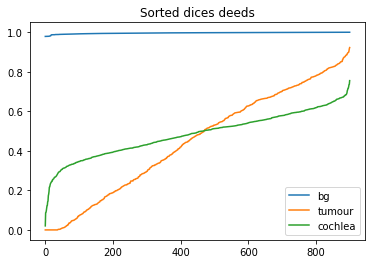

In [29]:
# print("swapdir", swap_dir)
print("unique moving_ids", len(moving_ids), sorted(moving_ids))
print("unique fixed_ids", len(fixed_ids), sorted(fixed_ids))
# ld_data_dict = torch.load(THIS_SCRIPT_DIR+"/data/crossmoda_convex.pth")
ld_data_dict = data_dict
dices = []
for fid, fx in ld_data_dict.items():
    for mid, mov in fx.items():
        dices.append(mov['dice'])

tens_dices = torch.cat(dices)

plt.plot(sorted(tens_dices[:,0]), label='bg')
plt.plot(sorted(tens_dices[:,1]), label='tumour')
plt.plot(sorted(tens_dices[:,2]), label='cochlea')
plt.title("Sorted dices deeds")
plt.legend()
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print("Quantile tumour: ", np.quantile(tens_dices[:,1], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]))
print("Quantile cochlea: ", np.quantile(tens_dices[:,2], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]))

In [83]:
gt = []
wpl = []
tumour_dices = []
comb_keys = []

for key in fixed_keys:
    for mov_key in list(warped_label_dict[key].keys()):
        warped_label = warped_label_dict[key][mov_key]
        tumour_dice = ld_data_dict[key][mov_key]['dice'][0][1].item()
        orig_label = orig_label_dict[key]
        gt.append(orig_label)
        wpl.append(warped_label)
        tumour_dices.append(tumour_dice)
        comb_keys.append(f"f{key}_m{mov_key}")

wpl = torch.stack(wpl).to_dense()
gt = torch.stack(gt)
srt = torch.tensor(np.argsort(tumour_dices)).long()[-10:]
tumour_dices = [tumour_dices[idx] for idx in srt]
wpl = wpl[srt]
gt = gt[srt]

comb_keys = [comb_keys[idx] for idx in srt]
print(tumour_dices)
print(wpl.shape)
overlay_text_list = [f"{dc:.2f}_{key}" for key, dc in zip(comb_keys, tumour_dices)]

frame_elements = [idx%2==0 for idx in range(len(overlay_text_list))]

visualize_seg(in_type="batch_3D", reduce_dim="W",
    img=gt.unsqueeze(1), # Expert label in BW
    seg=wpl.long().cpu(), # Prediction in blue
    ground_truth=gt.long(), # Modified label in red
    # crop_to_non_zero_seg=True,
    crop_to_non_zero_gt=True,
    alpha_seg = .5,
    alpha_gt = .5,
    n_per_row=35,
    overlay_text=overlay_text_list,
    annotate_color=(0,255,255),
    frame_elements=frame_elements,
    file_path="out.png",
)
print("Done")

[0.6564920544624329, 0.6615490913391113, 0.66754150390625, 0.6853525638580322, 0.6961158514022827, 0.7095019817352295, 0.7232212424278259, 0.7998449206352234, 0.8001408576965332, 0.8199121356010437]
torch.Size([10, 128, 128, 128])
Done


In [44]:
if config_dict['do_plot']:
    training_dataset = prepare_data(config_dict)
    # Print bare 2D data
    # print("Displaying 2D bare sample")
    # for img, label in zip(training_dataset.img_data_2d.values(),
    #                       training_dataset.label_data_2d.values()):
    #     display_seg(in_type="single_2D",
    #                 img=img.unsqueeze(0),
    #                 ground_truth=label,
    #                 crop_to_non_zero_gt=True,
    #                 alpha_gt = .3)

    # Print transformed 2D data
    training_dataset.train(use_modified=False, augment=True)
    print(training_dataset.disturbed_idxs)

    print("Displaying 2D training sample")
    for dist_stren in [0.1, 0.2, 0.3, 0.5, 1.0, 2.0, 5.0]:
        print(dist_stren)
        training_dataset.disturb_idxs(list(range(0,20,2)),
            disturbance_mode=LabelDisturbanceMode.AFFINE,
            disturbance_strength=dist_stren
        )
        img_stack = []
        label_stack = []
        mod_label_stack = []

        for sample in (training_dataset[idx] for idx in range(20)):
            img_stack.append(sample['image'])
            label_stack.append(sample['label'])
            mod_label_stack.append(sample['modified_label'])

        # Change label num == hue shift for display
        img_stack = torch.stack(img_stack).unsqueeze(1)
        label_stack = torch.stack(label_stack)
        mod_label_stack = torch.stack(mod_label_stack)

        mod_label_stack*=4

        visualize_seg(in_type="batch_2D",
            img=img_stack,
            # ground_truth=label_stack,
            seg=(mod_label_stack-label_stack).abs(),
            # crop_to_non_zero_gt=True,
            crop_to_non_zero_seg=True,
            alpha_seg = .6,
            file_path=f'out{dist_stren}.png'
        )

    # Print transformed 3D data
    # training_dataset.train()
    # print("Displaying 3D training sample")
    # leng = 1# training_dataset.__len__(use_2d_override=False)
    # for sample in (training_dataset.get_3d_item(idx) for idx in range(leng)):
    #     # training_dataset.set_dilate_kernel_size(1)
    #     visualize_seg(in_type="single_3D", reduce_dim="W",
    #                 img=sample['image'].unsqueeze(0),
    #                 ground_truth=sample['label'],
    #                 crop_to_non_zero_gt=True,
    #                 alpha_gt = .3)

#         # training_dataset.set_dilate_kernel_size(7)
#         display_seg(in_type="single_3D", reduce_dim="W",
#                     img=sample['image'].unsqueeze(0),
#                     ground_truth=sample['modified_label'],
#                     crop_to_non_zero_gt=True,
#                     alpha_gt = .3)

    for sidx in [0,]:
        print(f"Sample {sidx}:")

        training_dataset.eval()
        sample_eval = training_dataset.get_3d_item(sidx)

        visualize_seg(in_type="single_3D", reduce_dim="W",
                    img=sample_eval['image'].unsqueeze(0),
                    ground_truth=sample_eval['label'],
                    crop_to_non_zero_gt=True,
                    alpha_gt = .3)

        visualize_seg(in_type="single_3D", reduce_dim="W",
                    img=sample_eval['image'].unsqueeze(0),
                    ground_truth=sample_eval['label'],
                    crop_to_non_zero_gt=True,
                    alpha_gt = .0)

        training_dataset.train()
        print("Train sample with ground-truth overlay")
        sample_train = training_dataset.get_3d_item(sidx)
        print(sample_train['label'].unique())
        visualize_seg(in_type="single_3D", reduce_dim="W",
                    img=sample_train['image'].unsqueeze(0),
                    ground_truth=sample_train['label'],
                    crop_to_non_zero_gt=True,
                    alpha_gt=.3)

        print("Eval/train diff with diff overlay")
        visualize_seg(in_type="single_3D", reduce_dim="W",
                    img=(sample_eval['image'] - sample_train['image']).unsqueeze(0),
                    ground_truth=(sample_eval['label'] - sample_train['label']).clamp(min=0),
                    crop_to_non_zero_gt=True,
                    alpha_gt = .3)

    train_plotset = (training_dataset.get_3d_item(idx) for idx in (55, 81, 63))
    for sample in train_plotset:
        print(f"Sample {sample['dataset_idx']}:")
        display_seg(in_type="single_3D", reduce_dim="W",
            img=sample_eval['image'].unsqueeze(0),
            ground_truth=sample_eval['label'],
            crop_to_non_zero_gt=True,
            alpha_gt = .6)
        display_seg(in_type="single_3D", reduce_dim="W",
            img=sample_eval['image'].unsqueeze(0),
            ground_truth=sample_eval['label'],
            crop_to_non_zero_gt=True,
            alpha_gt = .0)

In [ ]:
#Add functions to replace modules of a model
MOD_GET_FN = lambda self, key: self[int(key)] if isinstance(self, nn.Sequential) \
                                              else getattr(self, key)

def get_module(module, keychain):
    """Retrieves any module inside a pytorch module for a given keychain.
       module.named_ to retrieve valid keychains for layers.
    """

    return functools.reduce(MOD_GET_FN, keychain.split('.'), module)

def set_module(module, keychain, replacee):
    """Replaces any module inside a pytorch module for a given keychain with "replacee".
       Use module.named_modules() to retrieve valid keychains for layers.
       e.g.
       first_keychain = list(module.keys())[0]
       new_first_replacee = torch.nn.Conv1d(1,2,3)
       set_module(first_keychain, torch.nn.Conv1d(1,2,3))
    """

    key_list = keychain.split('.')
    root = functools.reduce(MOD_GET_FN, key_list[:-1], module)
    leaf = key_list[-1]
    if isinstance(root, nn.Sequential):
        root[int(leaf)] = replacee
    else:
        setattr(root, leaf, replacee)

In [ ]:
def save_model(_path, **statefuls):
    _path = Path(THIS_SCRIPT_DIR).joinpath(_path).resolve()
    _path.mkdir(exist_ok=True, parents=True)

    for name, stful in statefuls.items():
        if stful != None:
            torch.save(stful.state_dict(), _path.joinpath(name+'.pth'))



def get_model(config, dataset_len, num_classes, THIS_SCRIPT_DIR, _path=None, device='cpu'):
    _path = Path(THIS_SCRIPT_DIR).joinpath(_path).resolve()

    if config.use_mind:
        in_channels = 12
    else:
        in_channels = 1

    if config.use_2d_normal_to is not None:
        # Use vanilla torch model
        lraspp = torchvision.models.segmentation.lraspp_mobilenet_v3_large(
            pretrained=False, progress=True, num_classes=num_classes
        )
        set_module(lraspp, 'backbone.0.0',
            torch.nn.Conv2d(in_channels, 16, kernel_size=(3, 3), stride=(2, 2),
                            padding=(1, 1), bias=False)
        )
    else:
        # Use custom 3d model
        lraspp = MobileNet_LRASPP_3D(
            in_num=in_channels, num_classes=num_classes,
            use_checkpointing=True
        )

    # lraspp.register_parameter('sigmoid_offset', nn.Parameter(torch.tensor([0.])))
    lraspp.to(device)
    print(f"Param count lraspp: {sum(p.numel() for p in lraspp.parameters())}")

    optimizer = torch.optim.AdamW(lraspp.parameters(), lr=config.lr)
    scaler = amp.GradScaler()

    # Add data paramters embedding and optimizer
    if config.data_param_mode == str(DataParamMode.INSTANCE_PARAMS):
        embedding = nn.Embedding(dataset_len, 1, sparse=True)
        # p_offset = torch.zeros(1, layout=torch.strided, requires_grad=True)
        # p_offset.grad = torch.sparse_coo_tensor([[0]], 1., size=(1,))

        # embedding.register_parameter('sigmoid_offset', nn.Parameter(torch.tensor([0.])))
        # embedding.sigmoid_offset.register_hook(lambda grad: torch.sparse_coo_tensor([[0]], grad, size=(1,)))
        embedding = embedding.to(device)

    elif config.data_param_mode == str(DataParamMode.GRIDDED_INSTANCE_PARAMS):
        embedding = nn.Embedding(dataset_len*config.grid_size_y*config.grid_size_x, 1, sparse=True).to(device)
    else:
        embedding = None


    if str(config.data_param_mode) != str(DataParamMode.DISABLED):
        optimizer_dp = torch.optim.SparseAdam(
            embedding.parameters(), lr=config.lr_inst_param,
            betas=(0.9, 0.999), eps=1e-08)
        torch.nn.init.normal_(embedding.weight.data, mean=config.init_inst_param, std=0.00)

        if _path and _path.is_dir():
            print(f"Loading embedding and dp_optimizer from {_path}")
            optimizer_dp.load_state_dict(torch.load(_path.joinpath('optimizer_dp.pth'), map_location=device))
            embedding.load_state_dict(torch.load(_path.joinpath('embedding.pth'), map_location=device))

        print(f"Param count embedding: {sum(p.numel() for p in embedding.parameters())}")

    else:
        optimizer_dp = None

    if _path and _path.is_dir():
        print(f"Loading lr-aspp model, optimizers and grad scalers from {_path}")
        lraspp.load_state_dict(torch.load(_path.joinpath('lraspp.pth'), map_location=device))
        optimizer.load_state_dict(torch.load(_path.joinpath('optimizer.pth'), map_location=device))
        scaler.load_state_dict(torch.load(_path.joinpath('scaler.pth'), map_location=device))
    else:
        print("Generating fresh lr-aspp model, optimizer and grad scaler.")

    return (lraspp, optimizer, optimizer_dp, embedding, scaler)

In [ ]:
def get_global_idx(fold_idx, epoch_idx, max_epochs):
    # Get global index e.g. 2250 for fold_idx=2, epoch_idx=250 @ max_epochs<1000
    return 10**len(str(int(max_epochs)))*fold_idx + epoch_idx



def save_parameter_figure(_path, title, text, parameters, reweighted_parameters, dices):
    # Show weights and weights with compensation
    fig, axs = plt.subplots(1,2, figsize=(12, 4), dpi=80)
    sc1 = axs[0].scatter(
        range(len(parameters)),
        parameters.cpu().detach(), c=dices,s=1, cmap='plasma', vmin=0., vmax=1.)
    sc2 = axs[1].scatter(
        range(len(reweighted_parameters)),
        reweighted_parameters.cpu().detach(), s=1,c=dices, cmap='plasma', vmin=0., vmax=1.)

    fig.suptitle(title, fontsize=14)
    fig.text(0, 0, text)
    axs[0].set_title('Bare parameters')
    axs[1].set_title('Reweighted parameters')
    axs[0].set_ylim(-10, 10)
    axs[1].set_ylim(-3, 1)
    plt.colorbar(sc2)
    plt.savefig(_path)
    plt.clf()
    plt.close()



def calc_inst_parameters_in_target_pos_ratio(dpm, disturbed_inst_idxs, target_pos='min'):

    assert target_pos == 'min' or target_pos == 'max', "Value of target_pos must be 'min' or 'max'."
    descending = False if target_pos == 'min' else True

    target_len = len(disturbed_inst_idxs)

    disturbed_params = dpm.get_parameter_list(inst_keys=disturbed_inst_idxs)
    all_params = sorted(dpm.get_parameter_list(inst_keys='all'), reverse=descending)
    target_param_ids = [id(param) for param in all_params[:target_len]]

    ratio = [1. for param in disturbed_params if id(param) in target_param_ids]
    ratio = sum(ratio)/target_len
    return ratio

def log_data_parameter_stats(log_path, epx, data_parameters):
    """Log stats for data parameters on wandb."""
    wandb.log({f'{log_path}/highest': torch.max(data_parameters).item()}, step=epx)
    wandb.log({f'{log_path}/lowest': torch.min(data_parameters).item()}, step=epx)
    wandb.log({f'{log_path}/mean': torch.mean(data_parameters).item()}, step=epx)
    wandb.log({f'{log_path}/std': torch.std(data_parameters).item()}, step=epx)



def reset_determinism():
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)
    # torch.use_deterministic_algorithms(True)




def log_class_dices(log_prefix, log_postfix, class_dices, log_idx):
    if not class_dices:
        return

    for cls_name in class_dices[0].keys():
        log_path = f"{log_prefix}{cls_name}{log_postfix}"

        cls_dices = list(map(lambda dct: dct[cls_name], class_dices))
        mean_per_class =np.nanmean(cls_dices)
        print(log_path, f"{mean_per_class*100:.2f}%")
        wandb.log({log_path: mean_per_class}, step=log_idx)

def CELoss(logits, targets, bin_weight=None):
    # -logits[0,targets[0,0,0],0,0]+torch.log(logits[0,:,0,0].exp().sum())
    targets = torch.nn.functional.one_hot(targets).permute(0,3,1,2)
    loss = -targets*F.log_softmax(logits, 1)

    if bin_weight is not None:
        brdcast_shape = torch.Size((loss.shape[0], loss.shape[1], *((loss.dim()-2)*[1])))
        inv_weight = (bin_weight+np.exp(1)).log()+np.exp(1)
        inv_weight = inv_weight/inv_weight.mean()
        loss = inv_weight.view(brdcast_shape)*loss

    return loss.sum(dim=1)

In [ ]:
def map_embedding_idxs(idxs, grid_size_y, grid_size_x):
    with torch.no_grad():
        t_sz = grid_size_y * grid_size_x
        return ((idxs*t_sz).long().repeat(t_sz).view(t_sz, idxs.numel())+torch.tensor(range(t_sz)).to(idxs).view(t_sz,1)).permute(1,0).reshape(-1)

def inference_wrap(lraspp, img, use_2d, use_mind):
    with torch.inference_mode():
        b_img = img.unsqueeze(0).unsqueeze(0).float()
        if use_2d and use_mind:
            # MIND 2D, in Bx1x1xHxW, out BxMINDxHxW
            b_img = mindssc(b_img.unsqueeze(0)).squeeze(2)
        elif not use_2d and use_mind:
            # MIND 3D in Bx1xDxHxW out BxMINDxDxHxW
            b_img = mindssc(b_img)
        elif use_2d or not use_2d:
            # 2D Bx1xHxW
            # 3D out Bx1xDxHxW
            pass

        b_out = lraspp(b_img)['out']
        b_out = b_out.argmax(1)
        return b_out

def train_DL(run_name, config, training_dataset):
    reset_determinism()

    # Configure folds
    kf = KFold(n_splits=config.num_folds)
    kf.get_n_splits(training_dataset)

    fold_iter = enumerate(kf.split(training_dataset))

    if config.get('fold_override', None):
        selected_fold = config.get('fold_override', 0)
        fold_iter = list(fold_iter)[selected_fold:selected_fold+1]
    elif config.only_first_fold:
        fold_iter = list(fold_iter)[0:1]

    if config.wandb_mode != 'disabled':
        # Log dataset info
        training_dataset.eval()
        dataset_info = [[smp['dataset_idx'], smp['id'], smp['image_path'], smp['label_path']] \
                        for smp in training_dataset]
        wandb.log({'datasets/training_dataset':wandb.Table(columns=['dataset_idx', 'id', 'image', 'label'], data=dataset_info)}, step=0)

    fold_means_no_bg = []

    for fold_idx, (train_idxs, val_idxs) in fold_iter:
        train_idxs = torch.tensor(train_idxs)
        val_idxs = torch.tensor(val_idxs)
        # Training happens in 2D, validation happens in 3D:
        # Read 2D dataset idxs which are used for training,
        # get their 3D super-ids and substract these from all 3D ids to get val_3d_idxs

        if config.use_2d_normal_to is not None:
            n_dims = (-2,-1)
            trained_3d_dataset_ids = training_dataset.get_3d_from_2d_identifiers(train_idxs, 'id')
            # trained_3d_trained_ids = training_dataset.switch_3d_identifiers(trained_3d_dataset_idxs)
            all_3d_ids = training_dataset.get_3d_ids()
            val_3d_ids = set(all_3d_ids) - set(trained_3d_dataset_ids)
            val_3d_idxs = list({
                training_dataset.extract_short_3d_id(_id):idx \
                    for idx, _id in enumerate(all_3d_ids) if _id in val_3d_ids}.values())
        else:
            n_dims = (-3,-2,-1)
            val_3d_idxs = val_idxs
        print("Will run validation with these 3D samples:", val_3d_idxs)

        _, _, all_modified_segs = training_dataset.get_data()

        non_empty_train_idxs = train_idxs[(all_modified_segs[train_idxs].sum(dim=n_dims) > 0)]

        ### Disturb dataset (only non-emtpy idxs)###
        proposed_disturbed_idxs = np.random.choice(non_empty_train_idxs, size=int(len(non_empty_train_idxs)*config.disturbed_percentage), replace=False)
        proposed_disturbed_idxs = torch.tensor(proposed_disturbed_idxs)
        training_dataset.disturb_idxs(proposed_disturbed_idxs,
            disturbance_mode=config.disturbance_mode,
            disturbance_strength=config.disturbance_strength
        )

        disturbed_bool_vect = torch.zeros(len(training_dataset))
        disturbed_bool_vect[training_dataset.disturbed_idxs] = 1.

        clean_idxs = train_idxs[np.isin(train_idxs, training_dataset.disturbed_idxs, invert=True)]
        print("Disturbed indexes:", sorted(training_dataset.disturbed_idxs))

        if clean_idxs.numel() < 200:
            print(f"Clean indexes: {sorted(clean_idxs.tolist())}")

        wandb.log({f'datasets/disturbed_idxs_fold{fold_idx}':wandb.Table(columns=['train_idxs'], data=[[idx] for idx in training_dataset.disturbed_idxs])},
            step=get_global_idx(fold_idx, 0, config.epochs))

        ### Configure MIND ###
        if config.use_mind:
            in_channels = 12
        else:
            in_channels = 1

        class_weights = 1/(torch.bincount(all_modified_segs.reshape(-1).long())).float().pow(.35)
        class_weights /= class_weights.mean()

        ### Add train sampler and dataloaders ##
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idxs)
        # val_subsampler = torch.utils.data.SubsetRandomSampler(val_idxs)

        train_dataloader = DataLoader(training_dataset, batch_size=config.batch_size,
            sampler=train_subsampler, pin_memory=True, drop_last=False,
            # collate_fn=training_dataset.get_efficient_augmentation_collate_fn()
        )

        training_dataset.set_augment_at_collate(False)

#         val_dataloader = DataLoader(training_dataset, batch_size=config.val_batch_size,
#                                     sampler=val_subsampler, pin_memory=True, drop_last=False)

        ### Get model, data parameters, optimizers for model and data parameters, as well as grad scaler ###
        epx_start = config.get('checkpoint_epx', 0)

        if config.checkpoint_name:
            # Load from checkpoint
            _path = f"{config.mdl_save_prefix}/{config.checkpoint_name}_fold{fold_idx}_epx{epx_start}"
        else:
            _path = f"{config.mdl_save_prefix}/{wandb.run.name}_fold{fold_idx}_epx{epx_start}"

        (lraspp, optimizer, optimizer_dp, embedding, scaler) = get_model(config, len(training_dataset), len(training_dataset.label_tags),
            THIS_SCRIPT_DIR=THIS_SCRIPT_DIR, _path=_path, device='cuda')

        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=500, T_mult=2)

        if optimizer_dp:
            scheduler_dp = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer_dp, T_0=500, T_mult=2)
        else:
            scheduler_dp = None

        t0 = time.time()

        # Prepare corr coefficient scoring
        training_dataset.eval(use_modified=True)
        wise_labels, mod_labels = list(zip(*[(sample['label'], sample['modified_label']) \
            for sample in training_dataset]))
        wise_labels, mod_labels = torch.stack(wise_labels), torch.stack(mod_labels)

        dice_func = dice2d if config.use_2d_normal_to is not None else dice3d

        wise_dice = dice_func(
            torch.nn.functional.one_hot(wise_labels, len(training_dataset.label_tags)),
            torch.nn.functional.one_hot(mod_labels, len(training_dataset.label_tags)),
            one_hot_torch_style=True, nan_for_unlabeled_target=False
        )

        gt_num = (mod_labels > 0).sum(dim=n_dims)
        t_metric = (gt_num+np.exp(1)).log()+np.exp(1)

        if str(config.data_param_mode) == str(DataParamMode.GRIDDED_INSTANCE_PARAMS):
            union_wise_mod_label = torch.logical_or(wise_labels, mod_labels)
            union_wise_mod_label = union_wise_mod_label.cuda()

        class_weights = class_weights.cuda()
        gt_num = gt_num.cuda()
        t_metric = t_metric.cuda()

        for epx in range(epx_start, config.epochs):
            global_idx = get_global_idx(fold_idx, epx, config.epochs)

            lraspp.train()

            ### Disturb samples ###
            training_dataset.train(use_modified=(epx >= config.start_disturbing_after_ep))
            wandb.log({"use_modified": float(training_dataset.use_modified)}, step=global_idx)

            epx_losses = []
            dices = []
            class_dices = []

            # Load data
            for batch_idx, batch in enumerate(train_dataloader):

                optimizer.zero_grad()
                if optimizer_dp:
                    optimizer_dp.zero_grad()

                b_img = batch['image']
                b_seg = batch['label']
                b_spat_aug_grid = batch['spat_augment_grid']

                b_seg_modified = batch['modified_label']
                b_idxs_dataset = batch['dataset_idx']
                b_img = b_img.float()

                b_img = b_img.cuda()
                b_seg_modified = b_seg_modified.cuda()
                b_idxs_dataset = b_idxs_dataset.cuda()
                b_seg = b_seg.cuda()
                b_spat_aug_grid = b_spat_aug_grid.cuda()

                if training_dataset.use_2d() and config.use_mind:
                    # MIND 2D, in Bx1x1xHxW, out BxMINDxHxW
                    b_img = mindssc(b_img.unsqueeze(1).unsqueeze(1)).squeeze(2)
                elif not training_dataset.use_2d() and config.use_mind:
                    # MIND 3D
                    b_img = mindssc(b_img.unsqueeze(1))
                else:
                    b_img = b_img.unsqueeze(1)

                ### Forward pass ###
                with amp.autocast(enabled=True):
                    assert b_img.dim() == len(n_dims)+2, \
                        f"Input image for model must be {len(n_dims)+2}D: BxCxSPATIAL but is {b_img.shape}"

                    logits = lraspp(b_img)['out']

                    ### Calculate loss ###
                    assert logits.dim() == len(n_dims)+2, \
                        f"Input shape for loss must be BxNUM_CLASSESxSPATIAL but is {logits.shape}"
                    assert b_seg_modified.dim() == len(n_dims)+1, \
                        f"Target shape for loss must be BxSPATIAL but is {b_seg_modified.shape}"

                    if config.data_param_mode == str(DataParamMode.INSTANCE_PARAMS):
                        # batch_bins = torch.zeros([len(b_idxs_dataset), len(training_dataset.label_tags)]).to(logits.device)
                        # bin_list = [slc.view(-1).bincount() for slc in b_seg_modified]
                        # for b_idx, _bins in enumerate(bin_list):
                        #     batch_bins[b_idx][:len(_bins)] = _bins
                        # loss = CELoss(logits, b_seg_modified, bin_weight=batch_bins)

                        loss = nn.CrossEntropyLoss(reduction='none')(logits, b_seg_modified)
                        loss = loss.mean(n_dims)

                        bare_weight = embedding(b_idxs_dataset).squeeze()

                        weight = torch.sigmoid(bare_weight)
                        weight = weight/weight.mean()

                        # This improves scores significantly: Reweight with log(gt_numel)
                        weight = weight/t_metric[b_idxs_dataset]

                        # Prepare logits for scoring
                        logits_for_score = logits.argmax(1)

                        if config.use_risk_regularization:
                            p_pred_num = (logits_for_score > 0).sum(dim=n_dims).detach()
                            risk_regularization = -weight*p_pred_num/(logits_for_score.shape[-2]*logits_for_score.shape[-1])
                            loss = (loss*weight).sum() + risk_regularization.sum()
                        else:
                            loss = (loss*weight).sum()

                    elif config.data_param_mode == str(DataParamMode.GRIDDED_INSTANCE_PARAMS):
                        loss = nn.CrossEntropyLoss(reduction='none')(logits, b_seg_modified)
                        m_dp_idxs = map_embedding_idxs(b_idxs_dataset, config.grid_size_y, config.grid_size_x)
                        weight = embedding(m_dp_idxs)
                        weight = weight.reshape(-1, config.grid_size_y, config.grid_size_x)
                        weight = weight.unsqueeze(1)
                        weight = torch.nn.functional.interpolate(
                            weight,
                            size=(b_seg_modified.shape[-2:]),
                            mode='bilinear',
                            align_corners=True
                        )
                        weight = weight/weight.mean()
                        weight = F.grid_sample(weight, b_spat_aug_grid,
                            padding_mode='border', align_corners=False)
                        loss = (loss.unsqueeze(1)*weight).sum()

                        # Prepare logits for scoring
                        logits_for_score = (logits*weight).argmax(1)

                    else:
                        loss = nn.CrossEntropyLoss(class_weights)(logits, b_seg_modified)
                        # Prepare logits for scoring
                        logits_for_score = logits.argmax(1)

                scaler.scale(loss).backward()
                scaler.step(optimizer)

                if str(config.data_param_mode) != str(DataParamMode.DISABLED):
                    scaler.step(optimizer_dp)

                scaler.update()

                epx_losses.append(loss.item())

                # Calculate dice score
                b_dice = dice_func(
                    torch.nn.functional.one_hot(logits_for_score, len(training_dataset.label_tags)),
                    torch.nn.functional.one_hot(b_seg, len(training_dataset.label_tags)), # Calculate dice score with original segmentation (no disturbance)
                    one_hot_torch_style=True
                )

                dices.append(get_batch_dice_over_all(
                    b_dice, exclude_bg=True))
                class_dices.append(get_batch_dice_per_class(
                    b_dice, training_dataset.label_tags, exclude_bg=True))

                ###  Scheduler management ###
                if config.use_cosine_annealing:
                    scheduler.step()

                if config.save_dp_figures and batch_idx % 10 == 0:
                    # Output data parameter figure
                    train_params = embedding.weight[train_idxs].squeeze()
                    # order = np.argsort(train_params.cpu().detach()) # Order by DP value
                    order = torch.arange(len(train_params))
                    wise_corr_coeff = np.corrcoef(train_params.cpu().detach(), wise_dice[train_idxs][:,1].cpu().detach())[0,1]
                    dp_figure_path = Path(f"data/output_figures/{wandb.run.name}_fold{fold_idx}/dp_figure_epx{epx:03d}_batch{batch_idx:03d}.png")
                    dp_figure_path.parent.mkdir(parents=True, exist_ok=True)
                    save_parameter_figure(dp_figure_path, wandb.run.name, f"corr. coeff. DP vs. dice(expert label, train gt): {wise_corr_coeff:4f}",
                        train_params[order], train_params[order]/t_metric[train_idxs][order], dices=wise_dice[train_idxs][:,1][order])

                if config.debug:
                    break

            ### Logging ###
            print(f"### Log epoch {epx} @ {time.time()-t0:.2f}s")
            print("### Training")
            ### Log wandb data ###
            # Log the epoch idx per fold - so we can recover the diagram by setting
            # ref_epoch_idx as x-axis in wandb interface
            wandb.log({"ref_epoch_idx": epx}, step=global_idx)

            mean_loss = torch.tensor(epx_losses).mean()
            wandb.log({f'losses/loss_fold{fold_idx}': mean_loss}, step=global_idx)

            mean_dice = np.nanmean(dices)
            print(f'dice_mean_wo_bg_fold{fold_idx}', f"{mean_dice*100:.2f}%")
            wandb.log({f'scores/dice_mean_wo_bg_fold{fold_idx}': mean_dice}, step=global_idx)

            log_class_dices("scores/dice_mean_", f"_fold{fold_idx}", class_dices, global_idx)

            # Log data parameters of disturbed samples
            if str(config.data_param_mode) != str(DataParamMode.DISABLED):
                # Calculate dice score corr coeff (unknown to network)
                train_params = embedding.weight[train_idxs].squeeze()
                order = np.argsort(train_params.cpu().detach())
                wise_corr_coeff = np.corrcoef(train_params[order].cpu().detach(), wise_dice[train_idxs][:,1][order].cpu().detach())[0,1]

                wandb.log(
                    {f'data_parameters/wise_corr_coeff_fold{fold_idx}': wise_corr_coeff},
                    step=global_idx
                )
                print(f'data_parameters/wise_corr_coeff_fold{fold_idx}', f"{wise_corr_coeff:.2f}")

                # Log stats of data parameters and figure
                log_data_parameter_stats(f'data_parameters/iter_stats_fold{fold_idx}', global_idx, embedding.weight.data)

                # Map gridded instance parameters
                if str(config.data_param_mode) == str(DataParamMode.GRIDDED_INSTANCE_PARAMS):
                    m_tr_idxs = map_embedding_idxs(train_idxs,
                        config.grid_size_y, config.grid_size_x
                    ).cuda()
                    masks = union_wise_mod_label[train_idxs].float()
                    masked_weights = torch.nn.functional.interpolate(
                        embedding(m_tr_idxs).view(-1,1,config.grid_size_y, config.grid_size_x),
                        size=(masks.shape[-2:]),
                        mode='bilinear',
                        align_corners=True
                    ).squeeze(1) * masks
                    masked_weights[masked_weights==0.] = float('nan')

            if (epx % config.save_every == 0 and epx != 0) \
                or (epx+1 == config.epochs):
                _path = f"{config.mdl_save_prefix}/{wandb.run.name}_fold{fold_idx}_epx{epx}"
                save_model(
                    _path,
                    lraspp=lraspp,
                    optimizer=optimizer, optimizer_dp=optimizer_dp,
                    scheduler=scheduler, scheduler_dp=scheduler_dp,
                    embedding=embedding,
                    scaler=scaler)
                (lraspp, optimizer, optimizer_dp, embedding, scaler) = \
                    get_model(
                        config, len(training_dataset),
                        len(training_dataset.label_tags),
                        THIS_SCRIPT_DIR=THIS_SCRIPT_DIR,
                        _path=_path, device='cuda')

            print()
            print("### Validation")
            lraspp.eval()
            training_dataset.eval()

            val_dices = []
            val_class_dices = []

            with amp.autocast(enabled=True):
                with torch.no_grad():
                    for val_idx in val_3d_idxs:
                        val_sample = training_dataset.get_3d_item(val_idx)
                        stack_dim = training_dataset.use_2d_normal_to
                        # Create batch out of single val sample
                        b_val_img = val_sample['image'].unsqueeze(0)
                        b_val_seg = val_sample['label'].unsqueeze(0)

                        B = b_val_img.shape[0]

                        b_val_img = b_val_img.unsqueeze(1).float().cuda()
                        b_val_seg = b_val_seg.cuda()

                        if training_dataset.use_2d():
                            b_val_img_2d = make_2d_stack_from_3d(b_val_img, stack_dim=training_dataset.use_2d_normal_to)

                            if config.use_mind:
                                # MIND 2D model, in Bx1x1xHxW, out BxMINDxHxW
                                b_val_img_2d = mindssc(b_val_img_2d.unsqueeze(1)).squeeze(2)

                            output_val = lraspp(b_val_img_2d)['out']
                            val_logits_for_score = output_val.argmax(1)
                            # Prepare logits for scoring
                            # Scoring happens in 3D again - unstack batch tensor again to stack of 3D
                            val_logits_for_score = make_3d_from_2d_stack(
                                val_logits_for_score.unsqueeze(1), stack_dim, B
                            ).squeeze(1)

                        else:
                            if config.use_mind:
                                # MIND 3D model shape BxMINDxDxHxW
                                b_val_img = mindssc(b_val_img)
                            else:
                                # 3D model shape Bx1xDxHxW
                                pass

                            output_val = lraspp(b_val_img)['out']
                            val_logits_for_score = output_val.argmax(1)

                        b_val_dice = dice3d(
                            torch.nn.functional.one_hot(val_logits_for_score, len(training_dataset.label_tags)),
                            torch.nn.functional.one_hot(b_val_seg, len(training_dataset.label_tags)),
                            one_hot_torch_style=True
                        )

                        # Get mean score over batch
                        val_dices.append(get_batch_dice_over_all(
                            b_val_dice, exclude_bg=True))

                        val_class_dices.append(get_batch_dice_per_class(
                            b_val_dice, training_dataset.label_tags, exclude_bg=True))

                        if config.do_plot:
                            print(f"Validation 3D image label/ground-truth {val_3d_idxs}")
                            print(get_batch_dice_over_all(
                            b_val_dice, exclude_bg=False))
                            # display_all_seg_slices(b_seg.unsqueeze(1), logits_for_score)
                            display_seg(in_type="single_3D",
                                reduce_dim="W",
                                img=val_sample['image'].unsqueeze(0).cpu(),
                                seg=val_logits_for_score_3d.squeeze(0).cpu(), # CHECK TODO
                                ground_truth=b_val_seg.squeeze(0).cpu(),
                                crop_to_non_zero_seg=True,
                                crop_to_non_zero_gt=True,
                                alpha_seg=.3,
                                alpha_gt=.0
                            )

                    mean_val_dice = np.nanmean(val_dices)
                    print(f'val_dice_mean_wo_bg_fold{fold_idx}', f"{mean_val_dice*100:.2f}%")
                    wandb.log({f'scores/val_dice_mean_wo_bg_fold{fold_idx}': mean_val_dice}, step=global_idx)
                    log_class_dices("scores/val_dice_mean_", f"_fold{fold_idx}", val_class_dices, global_idx)

            print()
            # End of training loop

            if config.debug:
                break

        if str(config.data_param_mode) != str(DataParamMode.DISABLED):
            # Write sample data

            training_dataset.eval(use_modified=True)
            all_idxs = torch.tensor(range(len(training_dataset))).cuda()
            train_label_snapshot_path = Path(THIS_SCRIPT_DIR).joinpath(f"data/output/{wandb.run.name}_fold{fold_idx}_epx{epx}/train_label_snapshot.pth")
            seg_viz_out_path = Path(THIS_SCRIPT_DIR).joinpath(f"data/output/{wandb.run.name}_fold{fold_idx}_epx{epx}/data_parameter_weighted_samples.png")

            train_label_snapshot_path.parent.mkdir(parents=True, exist_ok=True)

            if str(config.data_param_mode) == str(DataParamMode.INSTANCE_PARAMS):
                dp_weights = embedding(all_idxs)
                save_data = []
                data_generator = zip(
                    dp_weights[train_idxs], \
                    disturbed_bool_vect[train_idxs],
                    torch.utils.data.Subset(training_dataset, train_idxs)
                )

                for dp_weight, disturb_flg, sample in data_generator:
                    data_tuple = ( \
                        dp_weight,
                        bool(disturb_flg.item()),
                        sample['id'],
                        sample['dataset_idx'],
                        sample['image'],
                        sample['label'],
                        sample['modified_label'],
                        inference_wrap(lraspp, sample['image'].cuda(), use_2d=training_dataset.use_2d(), use_mind=config.use_mind)
                    )
                    save_data.append(data_tuple)

                save_data = sorted(save_data, key=lambda tpl: tpl[0])
                (dp_weight, disturb_flags,
                 d_ids, dataset_idxs, _imgs,
                 _labels, _modified_labels, _predictions) = zip(*save_data)

                dp_weight = torch.stack(dp_weight)
                dataset_idxs = torch.stack(dataset_idxs)
                _imgs = torch.stack(_imgs)
                _labels = torch.stack(_labels)
                _modified_labels = torch.stack(_modified_labels)
                _predictions = torch.stack(_predictions)

                torch.save(
                    {
                        'data_parameters': dp_weight.cpu(),
                        'disturb_flags': disturb_flags,
                        'd_ids': d_ids,
                        'dataset_idxs': dataset_idxs.cpu(),
                        'labels': _labels.cpu().to_sparse(),
                        'modified_labels': _modified_labels.cpu().to_sparse(),
                        'train_predictions': _predictions.cpu().to_sparse(),
                    },
                    train_label_snapshot_path
                )

            elif str(config.data_param_mode) == str(DataParamMode.GRIDDED_INSTANCE_PARAMS):
                # Log histogram of clean and disturbed parameters
                if not training_dataset.use_2d():
                    raise NotImplementedError("Script does not support 3D model and GRIDDED_INSTANCE_PARAMS yet.")

                m_all_idxs = map_embedding_idxs(all_idxs,
                        config.grid_size_y, config.grid_size_x
                ).cuda()
                masks = union_wise_mod_label[all_idxs].float()
                all_weights = torch.nn.functional.interpolate(
                    embedding(m_all_idxs).view(-1,1,config.grid_size_y, config.grid_size_x),
                    size=(masks.shape[-2:]),
                    mode='bilinear',
                    align_corners=True
                ).squeeze(1)

                masked_weights = all_weights * masks
                masked_weights[masked_weights==0.] = float('nan')
                dp_weights = np.nanmean(masked_weights.detach().cpu(), axis=n_dims)

                weightmap_out_path = Path(THIS_SCRIPT_DIR).joinpath(f"data/output/{wandb.run.name}_fold{fold_idx}_epx{epx}/data_parameter_weightmap.png")

                save_data = []
                data_generator = zip(
                    dp_weights[train_idxs],
                    all_weights[train_idxs],
                    disturbed_bool_vect[train_idxs],
                    torch.utils.data.Subset(training_dataset,train_idxs)
                )

                for dp_weight, weightmap, disturb_flg, sample in data_generator:
                    data_tuple = (
                        dp_weight,
                        weightmap,
                        bool(disturb_flg.item()),
                        sample['id'],
                        sample['dataset_idx'],
                        sample['image'],
                        sample['label'],
                        sample['modified_label']
                    )
                    save_data.append(data_tuple)

                save_data = sorted(save_data, key=lambda tpl: tpl[0])

                (dp_weight, dp_weightmap, disturb_flags,
                 d_ids, dataset_idxs, _2d_imgs,
                 _2d_labels, _2d_modified_labels) = zip(*save_data)

                dp_weight = torch.stack(dp_weight)
                dp_weightmap = torch.stack(dp_weightmap)
                dataset_idxs = torch.stack(dataset_idxs)
                _2d_imgs = torch.stack(_2d_imgs)
                _2d_labels = torch.stack(_2d_labels)
                _2d_modified_labels = torch.stack(_2d_modified_labels)
                _2d_predictions = torch.stack(_2d_predictions)

                torch.save(
                    {
                        'data_parameters': dp_weight.cpu(),
                        'data_parameter_weightmaps': dp_weightmap.cpu(),
                        'disturb_flags': disturb_flags,
                        'd_ids': d_ids,
                        'dataset_idxs': dataset_idxs.cpu(),
                        'labels': _2d_labels.cpu().to_sparse(),
                        'modified_labels': _2d_modified_labels.cpu().to_sparse(),
                        'train_predictions': _2d_predictions.cpu().to_sparse(),
                    },
                    train_label_snapshot_path
                )

                print("Writing weight map image.")
                weightmap_out_path = Path(THIS_SCRIPT_DIR).joinpath(f"data/output/{wandb.run.name}_fold{fold_idx}_epx{epx}_data_parameter_weightmap.png")
                visualize_seg(in_type="batch_2D",
                    img=torch.stack(dp_weightmap).unsqueeze(1),
                    seg=torch.stack(_2d_modified_labels),
                    alpha_seg = 0.,
                    n_per_row=70,
                    overlay_text=overlay_text_list,
                    annotate_color=(0,255,255),
                    frame_elements=disturb_flags,
                    file_path=weightmap_out_path,
                )

            if len(training_dataset.disturbed_idxs) > 0:
                # Log histogram
                separated_params = list(zip(dp_weights[clean_idxs], dp_weights[training_dataset.disturbed_idxs]))
                s_table = wandb.Table(columns=['clean_idxs', 'disturbed_idxs'], data=separated_params)
                fields = {"primary_bins" : "clean_idxs", "secondary_bins" : "disturbed_idxs", "title" : "Data parameter composite histogram"}
                composite_histogram = wandb.plot_table(vega_spec_name="rap1ide/composite_histogram", data_table=s_table, fields=fields)
                wandb.log({f"data_parameters/separated_params_fold_{fold_idx}": composite_histogram})

            # Write out data of modified and un-modified labels and an overview image
            print("Writing train sample image.")
            # overlay text example: d_idx=0, dp_i=1.00, dist? False
            overlay_text_list = [f"id:{d_id} dp:{instance_p.item():.2f}" \
                for d_id, instance_p, disturb_flg in zip(d_ids, dp_weight, disturb_flags)]

            if training_dataset.use_2d():
                reduce_dim = None
                in_type = "batch_2D"
            else:
                reduce_dim = "W"
                in_type = "batch_3D"

            use_2d = training_dataset.use_2d()
            scf = 1/training_dataset.pre_interpolation_factor

            show_img = interpolate_sample(b_label=_labels, scale_factor=scf, use_2d=use_2d)[1].unsqueeze(1)
            show_seg = interpolate_sample(b_label=4*_predictions.squeeze(1), scale_factor=scf, use_2d=use_2d)[1]
            show_gt = interpolate_sample(b_label=_modified_labels, scale_factor=scf, use_2d=use_2d)[1]

            visualize_seg(in_type=in_type, reduce_dim=reduce_dim,
                img=show_img, # Expert label in BW
                seg=show_seg, # Prediction in blue
                ground_truth=show_gt, # Modified label in red
                crop_to_non_zero_seg=False,
                alpha_seg = .5,
                alpha_gt = .5,
                n_per_row=70,
                overlay_text=overlay_text_list,
                annotate_color=(0,255,255),
                frame_elements=disturb_flags,
                file_path=seg_viz_out_path,
            )

        # End of fold loop

In [ ]:
# Config overrides
# config_dict['wandb_mode'] = 'disabled'
# config_dict['debug'] = True
# Model loading
# config_dict['checkpoint_name'] = 'treasured-water-717'
# # config_dict['fold_override'] = 0
# config_dict['checkpoint_epx'] = 39

# Define sweep override dict
sweep_config_dict = dict(
    method='grid',
    metric=dict(goal='maximize', name='scores/val_dice_mean_tumour_fold0'),
    parameters=dict(
        # disturbance_mode=dict(
        #     values=[
        #        'LabelDisturbanceMode.AFFINE',
        #     ]
        # ),
        #     values=[
        #        'LabelDisturbanceMode.AFFINE',
        #     ]
        # ),
        # reg_state=dict(
        #     values=['best','combined']
        # ),
        disturbance_strength=dict(
            values=[0.1, 0.2, 0.5, 1.0, 2.0, 5.0]
        ),
        disturbed_percentage=dict(
            values=[0.3, 0.6]
        ),
        data_param_mode=dict(
            values=[
                DataParamMode.INSTANCE_PARAMS,
                DataParamMode.DISABLED,
            ]
        ),
        # use_risk_regularization=dict(
        #     values=[False, True]
        # )
    )
)

In [ ]:
def normal_run():
    with wandb.init(project="curriculum_deeplab", group="training", job_type="train",
            config=config_dict, settings=wandb.Settings(start_method="thread"),
            mode=config_dict['wandb_mode']
        ) as run:

        run_name = run.name
        config = wandb.config
        training_dataset = prepare_data(config)
        train_DL(run_name, config, training_dataset)

def sweep_run():
    with wandb.init() as run:
        run = wandb.init(
            settings=wandb.Settings(start_method="thread"),
            mode=config_dict['wandb_mode']
        )

        run_name = run.name
        config = wandb.config
        training_dataset = prepare_data(config)
        train_DL(run_name, config, training_dataset)


if config_dict['do_sweep']:
    # Integrate all config_dict entries into sweep_dict.parameters -> sweep overrides config_dict
    cp_config_dict = copy.deepcopy(config_dict)
    # cp_config_dict.update(copy.deepcopy(sweep_config_dict['parameters']))
    for del_key in sweep_config_dict['parameters'].keys():
        if del_key in cp_config_dict:
            del cp_config_dict[del_key]
    merged_sweep_config_dict = copy.deepcopy(sweep_config_dict)
    # merged_sweep_config_dict.update(cp_config_dict)
    for key, value in cp_config_dict.items():
        merged_sweep_config_dict['parameters'][key] = dict(value=value)
    # Convert enum values in parameters to string. They will be identified by their numerical index otherwise
    for key, param_dict in merged_sweep_config_dict['parameters'].items():
        if 'value' in param_dict and isinstance(param_dict['value'], Enum):
            param_dict['value'] = str(param_dict['value'])
        if 'values' in param_dict:
            param_dict['values'] = [str(elem) if isinstance(elem, Enum) else elem for elem in param_dict['values']]

        merged_sweep_config_dict['parameters'][key] = param_dict

    sweep_id = wandb.sweep(merged_sweep_config_dict, project="curriculum_deeplab")
    wandb.agent(sweep_id, function=sweep_run)

else:
    normal_run()

In [ ]:
# def inference_DL(run_name, config, inf_dataset):

#     score_dicts = []

#     fold_iter = range(config.num_folds)
#     if config_dict['only_first_fold']:
#         fold_iter = fold_iter[0:1]

#     for fold_idx in fold_iter:
#         lraspp, *_ = load_model(f"{config.mdl_save_prefix}_fold{fold_idx}", config, len(validation_dataset))

#         lraspp.eval()
#         inf_dataset.eval()
#         stack_dim = config.use_2d_normal_to

#         inf_dices = []
#         inf_dices_tumour = []
#         inf_dices_cochlea = []

#         for inf_sample in inf_dataset:
#             global_idx = get_global_idx(fold_idx, sample_idx, config.epochs)
#             crossmoda_id = sample['crossmoda_id']
#             with amp.autocast(enabled=True):
#                 with torch.no_grad():

#                     # Create batch out of single val sample
#                     b_inf_img = inf_sample['image'].unsqueeze(0)
#                     b_inf_seg = inf_sample['label'].unsqueeze(0)

#                     B = b_inf_img.shape[0]

#                     b_inf_img = b_inf_img.unsqueeze(1).float().cuda()
#                     b_inf_seg = b_inf_seg.cuda()
#                     b_inf_img_2d = make_2d_stack_from_3d(b_inf_img, stack_dim=stack_dim)

#                     if config.use_mind:
#                         b_inf_img_2d = mindssc(b_inf_img_2d.unsqueeze(1)).squeeze(2)

#                     output_inf = lraspp(b_inf_img_2d)['out']

#                     # Prepare logits for scoring
#                     # Scoring happens in 3D again - unstack batch tensor again to stack of 3D
#                     inf_logits_for_score = make_3d_from_2d_stack(output_inf, stack_dim, B)
#                     inf_logits_for_score = inf_logits_for_score.argmax(1)

#                     inf_dice = dice3d(
#                         torch.nn.functional.one_hot(inf_logits_for_score, 3),
#                         torch.nn.functional.one_hot(b_inf_seg, 3),
#                         one_hot_torch_style=True
#                     )
#                     inf_dices.append(get_batch_dice_wo_bg(inf_dice))
#                     inf_dices_tumour.append(get_batch_dice_tumour(inf_dice))
#                     inf_dices_cochlea.append(get_batch_dice_cochlea(inf_dice))

#                     if config.do_plot:
#                         print("Inference 3D image label/ground-truth")
#                         print(inf_dice)
#                         # display_all_seg_slices(b_seg.unsqueeze(1), logits_for_score)
#                         display_seg(in_type="single_3D",
#                             reduce_dim="W",
#                             img=inf_sample['image'].unsqueeze(0).cpu(),
#                             seg=inf_logits_for_score.squeeze(0).cpu(),
#                             ground_truth=b_inf_seg.squeeze(0).cpu(),
#                             crop_to_non_zero_seg=True,
#                             crop_to_non_zero_gt=True,
#                             alpha_seg=.4,
#                             alpha_gt=.2
#                         )

#             if config.debug:
#                 break

#         mean_inf_dice = np.nanmean(inf_dices)
#         mean_inf_dice_tumour = np.nanmean(inf_dices_tumour)
#         mean_inf_dice_cochlea = np.nanmean(inf_dices_cochlea)

#         print(f'inf_dice_mean_wo_bg_fold{fold_idx}', f"{mean_inf_dice*100:.2f}%")
#         print(f'inf_dice_mean_tumour_fold{fold_idx}', f"{mean_inf_dice_tumour*100:.2f}%")
#         print(f'inf_dice_mean_cochlea_fold{fold_idx}', f"{mean_inf_dice_cochlea*100:.2f}%")
#         wandb.log({f'scores/inf_dice_mean_wo_bg_fold{fold_idx}': mean_inf_dice}, step=global_idx)
#         wandb.log({f'scores/inf_dice_mean_tumour_fold{fold_idx}': mean_inf_dice_tumour}, step=global_idx)
#         wandb.log({f'scores/inf_dice_mean_cochlea_fold{fold_idx}': mean_inf_dice_cochlea}, step=global_idx)

#         # Store data for inter-fold scoring
#         class_dice_list = inf_dices.tolist()[0]
#         for class_idx, class_dice in enumerate(class_dice_list):
#             score_dicts.append(
#                 {
#                     'fold_idx': fold_idx,
#                     'crossmoda_id': crossmoda_id,
#                     'class_idx': class_idx,
#                     'class_dice': class_dice,
#                 }
#             )

#     mean_oa_inf_dice = np.nanmean(torch.tensor([score['class_dice'] for score in score_dicts]))
#     print(f"Mean dice over all folds, classes and samples: {mean_oa_inf_dice*100:.2f}%")
#     wandb.log({'scores/mean_dice_all_folds_samples_classes': mean_oa_inf_dice}, step=global_idx)

#     return score_dicts

In [ ]:
# folds_scores = []
# run = wandb.init(project="curriculum_deeplab", name=run_name, group=f"testing", job_type="test",
#         config=config_dict, settings=wandb.Settings(start_method="thread"),
#         mode=config_dict['wandb_mode']
# )
# config = wandb.config
# score_dicts = inference_DL(run_name, config, validation_dataset)
# folds_scores.append(score_dicts)
# wandb.finish()